# AlongTrack Data - SWOT

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing.spatial import transform_360_to_180
from oceanbench._src.geoprocessing.subset import where_slice
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


## Data

In [2]:
!ls "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/"

2020a_SSH_mapping_NATL60_envisat.nc
2020a_SSH_mapping_NATL60_geosat2.nc
2020a_SSH_mapping_NATL60_jason1.nc
2020a_SSH_mapping_NATL60_karin_swot.nc
2020a_SSH_mapping_NATL60_nadir_swot.nc
2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc


In [48]:
files_nadir_dc20a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_jason1.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_geosat2.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_nadir_swot.nc",
]

files_swot_dc20a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_karin_swot.nc",
    
]

ds_swot = xr.open_dataset(files_swot_dc20a[0])

In [49]:
ds_swot

<xarray.Dataset>
Dimensions:      (nC: 52, time: 188121)
Coordinates:
  * nC           (nC) int64 0 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50 51
  * time         (time) datetime64[ns] 2012-10-02T18:03:42.401288 ... 2013-09...
Data variables: (12/14)
    lon          (nC, time) float64 ...
    lat          (nC, time) float64 ...
    x_al         (nC, time) float32 ...
    x_ac         (nC, time) float32 ...
    lon_nadir    (nC, time) float64 ...
    lat_nadir    (nC, time) float64 ...
    ...           ...
    ssh_obs      (nC, time) float64 ...
    roll_err     (nC, time) float64 ...
    phase_err    (nC, time) float64 ...
    ssh_model    (nC, time) float64 ...
    bd_err       (nC, time) float64 ...
    karin_err    (nC, time) float64 ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [50]:
def remove_swath_dimension(ds, name: str="nC"):
    
    return ds.rename({"time": "z"}).stack(time=(name, "z")).set_index({"time": "z"}).reset_coords([name]).sortby("time")

In [51]:
ds_swot_ = remove_swath_dimension(ds_swot, "nC")

In [55]:
def preprocess_nadir_dc20a(da, variable="ssh_mod"):
        
    da = da.rename({variable: "ssh"})
    
    da = da.sel(
        time=slice("2012-10-22", "2012-12-03"),
        drop=True
    ).compute()
    
    da["lon"] = transform_360_to_180(da["lon"])
    
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
    
    da = da.drop_dims("cycle")
        
    return da


def preprocess_swot_dc20a(da, variable="ssh_mod"):
    
    da = remove_swath_dimension(da, "nC")
        
    da = da.rename({variable: "ssh"})
    
    da = da.sel(
        time=slice("2012-10-22", "2012-12-03"),
        drop=True
    ).compute()
    
    da["lon"] = transform_360_to_180(da["lon"])
    
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
    
    da = da.sortby("time")
        
    return da

In [56]:
preprocess_fn = ft.partial(preprocess_nadir_dc20a, variable="ssh_model")

ds_nadir = xr.open_mfdataset(
    files_nadir_dc20a, 
    preprocess=preprocess_fn,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time")

ds_nadir

<xarray.Dataset>
Dimensions:      (time: 42468)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12...
Data variables:
    lon          (time) float64 -55.03 -55.06 -55.1 ... -64.89 -64.93 -64.97
    lat          (time) float64 39.58 39.53 39.47 39.42 ... 42.12 42.17 42.22
    x_al         (time) float32 1.008e+06 1.008e+06 ... 5.373e+06 5.373e+06
    model_index  (time) float32 515.0 515.0 515.0 ... 1.533e+03 1.533e+03
    ssh_obs      (time) float64 0.975 1.008 1.009 ... -0.0774 -0.0679 -0.0703
    ssh          (time) float64 0.9958 1.014 1.027 ... -0.0576 -0.0568 -0.051
    nadir_err    (time) float64 -0.0208 -0.0061 -0.0182 ... -0.0111 -0.0193
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [57]:
preprocess_fn = ft.partial(preprocess_swot_dc20a, variable="ssh_model")

ds_swot = xr.open_mfdataset(
    files_swot_dc20a, 
    preprocess=preprocess_fn,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_swot = ds_swot.sortby("time")

ds_swot

<xarray.Dataset>
Dimensions:      (time: 955000)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-23T18:04:12.393963 ... 2012-11...
Data variables: (12/15)
    lon          (time) float64 -55.4 -55.37 -55.39 ... -64.45 -64.47 -64.5
    lat          (time) float64 42.99 42.99 42.97 42.97 ... 42.98 42.99 42.99
    x_al         (time) float32 1.001e+06 1.001e+06 ... 1.01e+07 1.01e+07
    x_ac         (time) float32 -60.0 -58.0 -60.0 -58.0 ... -60.0 -58.0 -56.0
    lon_nadir    (time) float64 305.3 305.3 305.3 305.3 ... 294.8 294.8 294.8
    lat_nadir    (time) float64 43.12 43.12 43.1 43.1 ... 43.1 43.12 43.12 43.12
    ...           ...
    roll_err     (time) float64 -0.1154 -0.1116 -0.1102 ... 0.07341 0.07088
    phase_err    (time) float64 0.06866 0.06637 0.06041 ... 0.04271 0.04124
    ssh          (time) float64 -0.0096 -0.0116 -0.0083 ... -0.0444 -0.0518
    bd_err       (time) float64 0.009219 0.008615 ... -0.004289 -0.003999
    karin_err    (time) float64 -0.0198 0.0012 0.0096 ... 0.0122 -0.0247 -0.0235
    nC           (time) float64 0.0 1.0 0.0 1.0 2.0 3.0 ... 5.0 6.0 0.0 1.0 2.0
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [69]:
ds_swotnadir = xr.concat([ds_nadir, ds_swot], dim="time")
ds_swotnadir = ds_swotnadir.sortby("time")

In [70]:
ds_swotnadir

<xarray.Dataset>
Dimensions:      (time: 997468)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12...
Data variables: (12/16)
    lon          (time) float64 -55.03 -55.06 -55.1 ... -64.89 -64.93 -64.97
    lat          (time) float64 39.58 39.53 39.47 39.42 ... 42.12 42.17 42.22
    x_al         (time) float32 1.008e+06 1.008e+06 ... 5.373e+06 5.373e+06
    model_index  (time) float32 515.0 515.0 515.0 ... 1.533e+03 1.533e+03
    ssh_obs      (time) float64 0.975 1.008 1.009 ... -0.0774 -0.0679 -0.0703
    ssh          (time) float64 0.9958 1.014 1.027 ... -0.0576 -0.0568 -0.051
    ...           ...
    timing_err   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    roll_err     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    phase_err    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    bd_err       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    karin_err    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    nC           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [2]:
# %matplotlib inline

# fig, ax = plt.subplots()

# sub_ds = ds_nadir.isel(time=slice(0,None))
# pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds.ssh, s=0.1)
# ax.set(
#     xlabel="Longitude",
#     ylabel="Latitude",
# )

# plt.colorbar(pts, label="Sea Surface Height [m]")
# plt.tight_layout()
# plt.show()

### Gridding

In [58]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/

NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.decoded.nc
NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sss_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc


In [60]:
file_natl60 = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"


In [61]:
def open_natl60_reference(file, variable="gssh"):
    da = xr.open_dataset(file, decode_times=False)
    da["time"] = pd.to_datetime(da.time)
    da = da.sortby("time")
    da["lon"] = transform_360_to_180(da["lon"])
    da = da.sel(
        time=slice("2012-10-22", "2012-12-03"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    da = da.rename({variable: "ssh"})
    return da


In [63]:
ds_natl60 = open_natl60_reference(file_natl60, "ssh")

## Data Structure

In [64]:
from oceanbench._src.geoprocessing.gridding import coord_based_to_grid

In [65]:
ds_nadir_gridded = coord_based_to_grid(
    ds_nadir, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

In [66]:
ds_swot_gridded = coord_based_to_grid(
    ds_swot, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

In [71]:
ds_swotnadir_gridded = coord_based_to_grid(
    ds_swotnadir, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

In [ ]:
import holoviews as hv
hv.extension("matplotlib")

:Layout
   .HoloMap.NATL60    :HoloMap   [time]
      :QuadMesh   [lon,lat]   (NATL60)
   .HoloMap.NADIR     :HoloMap   [time]
      :QuadMesh   [lon,lat]   (NADIR)
   .HoloMap.SWOT      :HoloMap   [time]
      :QuadMesh   [lon,lat]   (SWOT)
   .HoloMap.SWOTNADIR :HoloMap   [time]
      :QuadMesh   [lon,lat]   (SWOTNADIR)
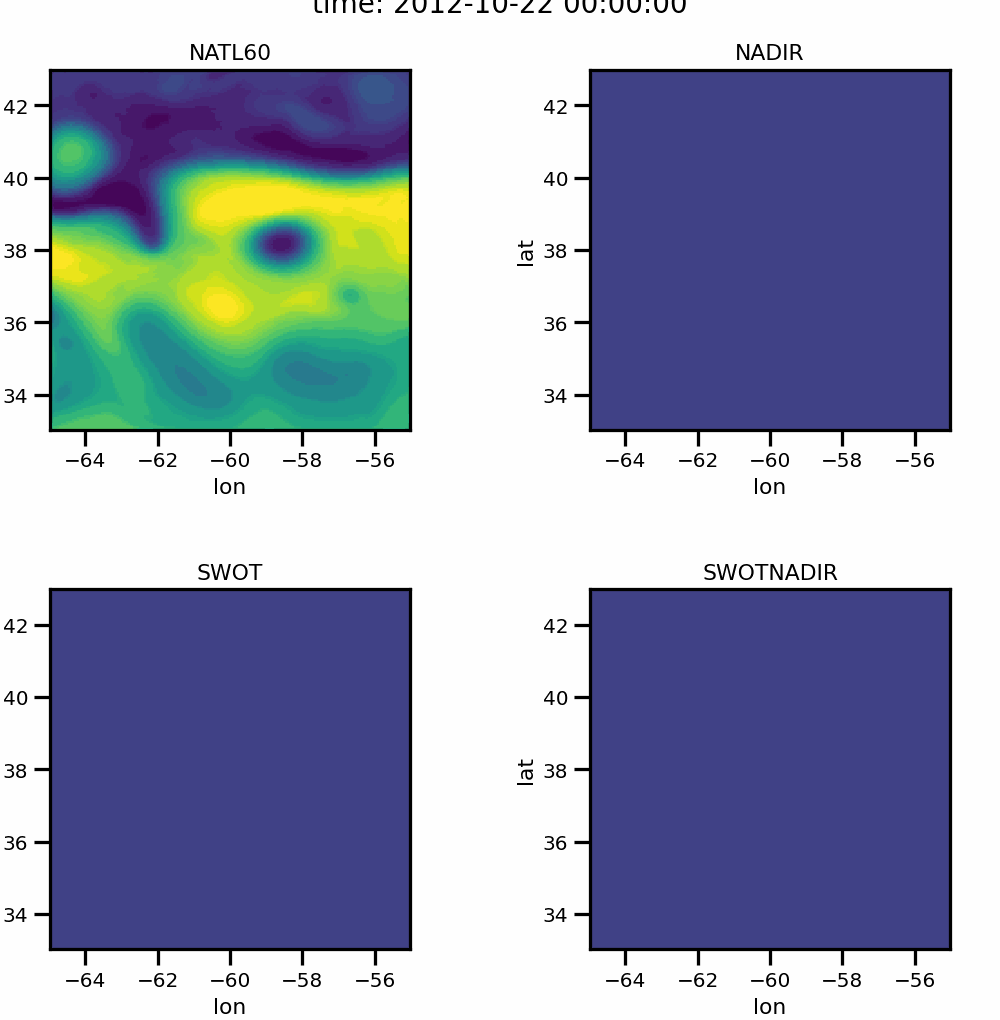

In [73]:
variable = "ssh" # "vort_r" # "ke" #  
cmap = "viridis" # "RdBu_r" # "YlGnBu_r" #
field_name = "NATL60"

ssh_ds = xr.Dataset({
    field_name: ds_natl60[variable],
    "NADIR": np.isfinite(ds_nadir_gridded[variable]),
    "SWOT": np.isfinite(ds_swot_gridded[variable]),
    "SWOTNADIR": np.isfinite(ds_swotnadir_gridded[variable]),
})


to_plot_ds = ssh_ds.transpose("time", "lat", "lon")#.isel(time=slice(25, 55, 1))

clim = (
    to_plot_ds[
        [field_name, "NADIR", "SWOT", "SWOTNADIR"]
    ].to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
)

images = hv.Layout([
    hv.Dataset(to_plot_ds)
    .to(hv.QuadMesh, ["lon", "lat"], v).relabel(v)
    .options(cmap=cmap, clim=clim)
    for v in to_plot_ds]
).cols(2).opts(sublabel_format="")

hv.output(images, holomap="gif", fps=2, dpi=125)